# I. Import dependencies

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

# II. Load data

In [2]:
X_train = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/X_train.csv", header=None)
y_train = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/y_train.csv", header=None)

X_test = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/X_test.csv", header=None)
y_test = pd.read_csv("/home/rakesh47/NNfromScratch/PreparedData/y_test.csv", header=None)

# III. User-defined hyperparameters

In [3]:
X_train.shape, y_train.shape

((354, 13), (354, 1))

In [4]:
# D_in is input dimension; H is hidden dimension; D_out is output dimension.

batch_size, D_in, H, D_out = 16, 13, 100, 1
learning_rate = 1e-6
n_epochs = 1000

# IV. Helper class

In [5]:
class RandomMatrix:
    "Generates a random 2D-matrix with given dimensions and gaussian distibution."
    
    def __init__(self, n_rows, n_cols, mu=0, sigma=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.mu = mu
        self.sigma = sigma
        self.matrix = [[random.gauss(mu, sigma) for _ in range(n_cols)] for _ in range(n_rows)]
        
        
    def size(self):
        return (self.n_rows, self.n_cols)
    
    
    def matmul(self, M):
        if self.n_cols != M.n_rows:  raise Exception("matmul not possible because n_cols of first matrix = " + str(self.n_cols) + " , which is NOT EQUAL TO n_rows of second matrix = " + str(M.n_cols))
        
        Result = RandomMatrix(self.n_rows, M.n_cols)
        for i in range(self.n_rows):
            for j in range(M.n_cols):
                res_ij = 0
                for k in range(self.n_cols):
                    res_ij += self.matrix[i][k] * M.matrix[k][j]
                Result.matrix[i][j] = res_ij
        
        return Result
    
    
    def relu(self):
        Result = RandomMatrix(self.n_rows, self.n_cols)
        Result.matrix = [[self.matrix[i][j] if self.matrix[i][j]>0 else 0. for j in range(self.n_cols)] for i in range(self.n_rows)]
        return Result
    
    
    def __sub__(self, M):
        if self.n_rows!=M.n_rows or self.n_cols!=M.n_cols:  raise Exception("__sub__ not possible because the matrics are not of same dimensions.")
        Result = RandomMatrix(self.n_rows, self.n_cols)
        Result.matrix = [[self.matrix[i][j]-M.matrix[i][j] for j in range(self.n_cols)] for i in range(self.n_rows)]
        return Result
    
    
    def __mul__(self, scalar):
        Result = RandomMatrix(self.n_rows, self.n_cols)
        Result.matrix = [[self.matrix[i][j]*scalar for j in range(self.n_cols)] for i in range(self.n_rows)]
        return Result
    
    
    def pow(self, p):
        Result = RandomMatrix(self.n_rows, self.n_cols)
        Result.matrix = [[self.matrix[i][j]**p for j in range(self.n_cols)] for i in range(self.n_rows)]
        return Result
    
    
    def sum(self):
        Result = 0.
        for i in range(self.n_rows):
            for j in range(self.n_cols):  Result += self.matrix[i][j]
        return Result
    
    
    def transpose(self):
        Result = RandomMatrix(self.n_cols, self.n_rows)
        Result.matrix = [[self.matrix[j][i] for j in range(self.n_rows)] for i in range(self.n_cols)]
        return Result
    
    
    def copy(self):
        Result = RandomMatrix(self.n_rows, self.n_cols)
        Result.matrix = [[self.matrix[i][j] for j in range(self.n_cols)] for i in range(self.n_rows)]
        return Result
    
    
    def arg_lt(self, val):
        Result = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):  
                if self.matrix[i][j] < val:  Result.append((i,j))
        return Result
    
    
    def arg_set(self, idxs, val):
        Result = self
        for (i, j) in idxs:  Result.matrix[i][j] = val

# V. Random weight initialization

In [6]:
w1 = RandomMatrix(D_in, H)
w2 = RandomMatrix(H, D_out)

# VI. Perform training : CPU

In [7]:
def train(data, batch_size, model, n_epochs):
    
    X_train, y_train, X_test, y_test = data
    w1, w2 = model
    train_losses = []
    val_losses = []
    for t in range(n_epochs):

        epoch_start = time.time()
        train_loss = 0.
        val_loss = 0.    
        for state in ['train', 'val']:        

            batch_start_idx = 0
            n_samples = len(X_train) if state=='train' else len(X_test)        
            while batch_start_idx < n_samples:

                # Get next batch of data 
                batch_end_idx = batch_start_idx + batch_size
                if batch_end_idx > n_samples:  batch_end_idx = n_samples
                x, y = RandomMatrix((batch_end_idx-batch_start_idx), X_train.shape[1]), RandomMatrix((batch_end_idx-batch_start_idx), y_train.shape[1])
                if state == 'train':  x.matrix, y.matrix = X_train.iloc[batch_start_idx:batch_end_idx, :].values, y_train.iloc[batch_start_idx:batch_end_idx, :].values
                else:  x.matrix, y.matrix = X_test.iloc[batch_start_idx:batch_end_idx, :].values, y_test.iloc[batch_start_idx:batch_end_idx, :].values

                # Forward pass: Compute output and loss
                h = x.matmul(w1)
                h_relu = h.relu()
                y_pred = h_relu.matmul(w2)
                loss = (y_pred - y).pow(2).sum()
                if state == 'train':  train_loss += loss
                else:  val_loss += loss

                # Backward pass: Compute gradients
                if state == 'train':
                    grad_y_pred = (y_pred - y) * 2.
                    grad_w2 = h_relu.transpose().matmul(grad_y_pred)
                    grad_h_relu = grad_y_pred.matmul(w2.transpose())
                    grad_h = grad_h_relu.copy()
                    lt_zero_idxs = h.arg_lt(0)
                    grad_h.arg_set(lt_zero_idxs, 0)
                    grad_w1 = x.transpose().matmul(grad_h)

                ## Update weights using gradient descent
                    w1 -= grad_w1 * learning_rate
                    w2 -= grad_w2 * learning_rate

                batch_start_idx = batch_end_idx

        # Print statistics
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        val_loss /= len(X_test)
        val_losses.append(val_loss)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        print("Epoch ", (t+1), "/", n_epochs, " : Train-loss = ", train_loss, ", Val-loss = ", val_loss, ", Time for epoch = ", epoch_time, "s")

    # Plot loss-curves
    plt.figure()
    plt.plot(range(2, n_epochs+1), train_losses[1:], label='Train-loss')
    plt.plot(range(2, n_epochs+1), val_losses[1:], label='Val-loss')
    plt.title('Loss curves')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(linestyle='dotted')
    plt.show()

Epoch  1 / 1000  : Train-loss =  2.68108478757e+14 , Val-loss =  571.794580109 , Time for epoch =  0.7516875267028809 s
Epoch  2 / 1000  : Train-loss =  603.05447488 , Val-loss =  569.780261682 , Time for epoch =  0.7436344623565674 s
Epoch  3 / 1000  : Train-loss =  597.550734819 , Val-loss =  566.213829666 , Time for epoch =  0.7400805950164795 s
Epoch  4 / 1000  : Train-loss =  589.939534494 , Val-loss =  554.597383723 , Time for epoch =  0.7374792098999023 s
Epoch  5 / 1000  : Train-loss =  564.089108569 , Val-loss =  517.611783807 , Time for epoch =  0.7522895336151123 s
Epoch  6 / 1000  : Train-loss =  418.345756526 , Val-loss =  200.243641196 , Time for epoch =  0.7561569213867188 s
Epoch  7 / 1000  : Train-loss =  137.45181049 , Val-loss =  125.939670805 , Time for epoch =  0.7500648498535156 s
Epoch  8 / 1000  : Train-loss =  111.730485966 , Val-loss =  129.444518409 , Time for epoch =  0.7469890117645264 s
Epoch  9 / 1000  : Train-loss =  109.159064722 , Val-loss =  131.48100

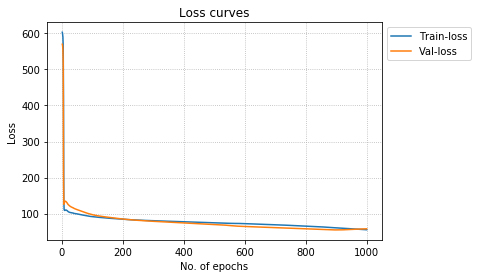

CPU times: user 12min 41s, sys: 980 ms, total: 12min 42s
Wall time: 12min 42s


In [8]:
%%time
train([X_train, y_train, X_test, y_test], batch_size, [w1, w2], n_epochs)